<div align="center">

# DSC4828 Assignment 7 Part 1  
### Ozzey Padayachee  
#### 64971759  

</div>


You have been appointed as the Lead Data Analyst to build a predictive model to determine if a building will have an insurance claim during a certain period or not. You will have to predict the probability of having at least one claim over the insured period of the building.The model will be based on the building characteristics. The target variable, Claim, is a:

    1 if the building has at least a claim over the insured period.
    0 if the building doesn’t have a claim over the insured period.

There are two datasets, test_data.csv and train_data.csv. Models will be trained on train_data and test_data will be used to make predictions for the competition submission. 

In [128]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [26]:
df_test = pd.read_csv('test_data.csv')
df_train = pd.read_csv('train_data.csv')

# Columns of df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.2+ KB


In [27]:
# Columns of df_test
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3069 entries, 0 to 3068
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         3069 non-null   object 
 1   YearOfObservation   3069 non-null   int64  
 2   Insured_Period      3069 non-null   float64
 3   Residential         3069 non-null   int64  
 4   Building_Painted    3069 non-null   object 
 5   Building_Fenced     3069 non-null   object 
 6   Garden              3065 non-null   object 
 7   Settlement          3069 non-null   object 
 8   Building Dimension  3056 non-null   float64
 9   Building_Type       3069 non-null   int64  
 10  Date_of_Occupancy   2341 non-null   float64
 11  NumberOfWindows     3069 non-null   object 
 12  Geo_Code            3056 non-null   object 
dtypes: float64(3), int64(3), object(7)
memory usage: 311.8+ KB


In [28]:
# Null values in df_train
print(df_train.isna().sum())

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64


In [29]:
# Null values in df_test
print(df_test.isna().sum())

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  4
Settlement              0
Building Dimension     13
Building_Type           0
Date_of_Occupancy     728
NumberOfWindows         0
Geo_Code               13
dtype: int64


We can see from calling .info() on both train and test datasets that they contain the same columns, except df_test does not contain the "Claim" column. For modeling purposes we will convert non-numeric columns to numeric, and replace data in columns that contain binary response variables, such as "Garden" with 1 or 0. The reason for this is that models work best with numeric data. Note also that the data are on different scales and measurements and scaling would be applicable in these cases. There are columns in the data with many NaN values, they will be replaced with the columns mean or mode contingent on the data being numeric or categorical. 

In [30]:
# Function to clean both train and test data
def clean_data(df):
    df['Building_Fenced'] = df['Building_Fenced'].apply(lambda x: 1 if x == 'N' else 0)
    df['Building_Painted'] = df['Building_Painted'].apply(lambda x: 1 if x == 'N' else 0)
    df['Garden'] = df['Garden'].apply(lambda x: 1 if x == 'V' else 0) # The NaN value counts are small, so I will assume them to be 0
    
    df['Settlement'] = df['Settlement'].apply(lambda x: 1 if x == 'U' else 0)
    
    df['NumberOfWindows'] = df['NumberOfWindows'].str.strip()
    df['NumberOfWindows'] = df['NumberOfWindows'].replace('.','0')
    df['NumberOfWindows'] = df['NumberOfWindows'].replace('>=10','10') # Here >=10 is a special character indicating there are more than 10 windows, we will just assume the max is 10 windows. 
    df['NumberOfWindows'] = df['NumberOfWindows'].astype(int)
    
    df['Building Dimension'] = df['Building Dimension'].fillna(
    df['Building Dimension'].mean())
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df.columns  = df.columns.str.lower().str.replace(' ', '_')
    return df
# Rename to train and test
train = clean_data(df_train) 
test = clean_data(df_test)

# Save the claim column, this will be our y
claim = train['claim']
test_ids = test.copy()
# These columns won't add much value to our modeling 
train = train.drop(columns=['customer_id','insured_period', 'yearofobservation', 'geo_code', 'date_of_occupancy']) 
test = test.drop(columns=['customer_id','insured_period', 'yearofobservation', 'geo_code','date_of_occupancy']) 

In [31]:
# Null values in df_test
print('\n\nTrain data\n',test.isna().sum(), '\n\nTest data\n', test.isna().sum())



Train data
 residential           0
building_painted      0
building_fenced       0
garden                0
settlement            0
building_dimension    0
building_type         0
numberofwindows       0
dtype: int64 

Test data
 residential           0
building_painted      0
building_fenced       0
garden                0
settlement            0
building_dimension    0
building_type         0
numberofwindows       0
dtype: int64


## Data Analysis

<Axes: >

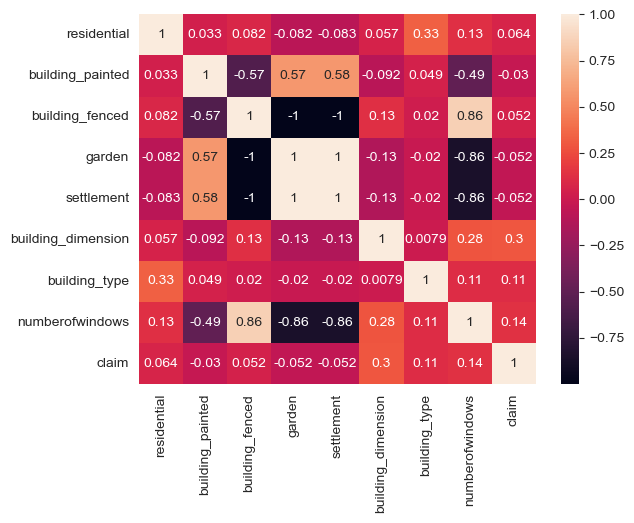

In [32]:
# Heat map showing the correlation between the features in train. 
sns.heatmap(train.corr(), annot=True)

Claim rates by building types, note that type 4 has higher claims

<Axes: xlabel='building_type'>

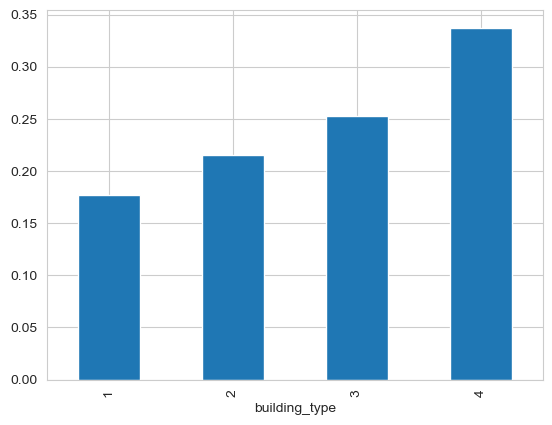

In [62]:
df_plot = df_train.copy()

claim_rate = df_plot.groupby('building_type')['claim'].mean()
claim_rate.plot(kind='bar')

Showing building type vs dimension and colour coded by claim, note that 1 has a higher spread 

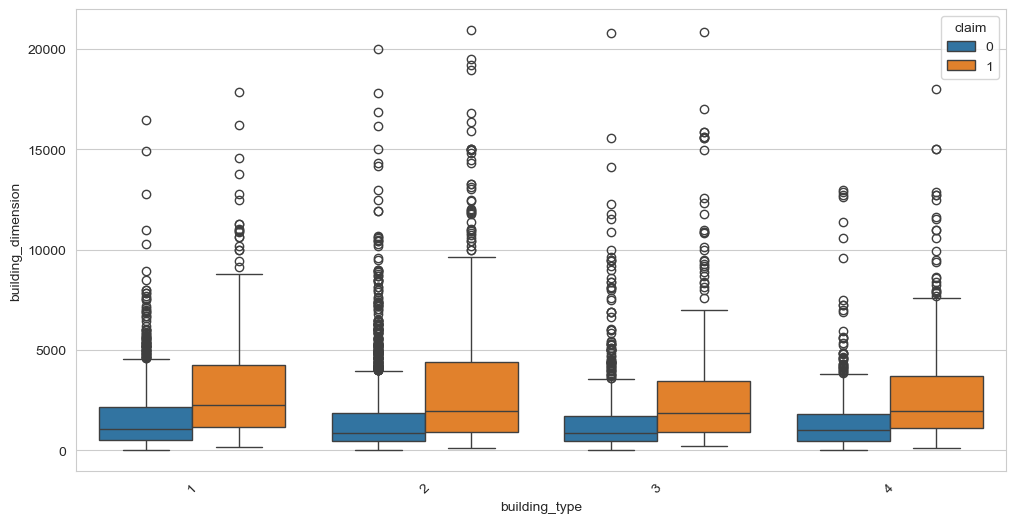

In [69]:
plt.figure(figsize=(12,6))
sns.boxplot(x='building_type', y='building_dimension', hue='claim', data=df_plot)
plt.xticks(rotation=45)
plt.show()

In [70]:
iqr_table = df_plot.groupby('building_type')['building_dimension'].quantile([0.25, 0.75]).unstack()
iqr_table['IQR'] = iqr_table[0.75] - iqr_table[0.25]
iqr_table = iqr_table.sort_values(by='IQR', ascending=False)

print(iqr_table)

                0.25     0.75      IQR
building_type                         
1              560.0  2451.75  1891.75
4              600.0  2457.00  1857.00
2              513.0  2188.00  1675.00
3              500.0  2107.50  1607.50


Building Type 1 exhibits the largest interquartile range (IQR = 1891.75), indicating substantial variability in building dimensions within this category. Building Type 3 shows the smallest IQR (1607.50), suggesting more standardized building sizes. 

What if we wanted to ask "Is building size statistically different between claim = 0 and claim = 1?". We can answer this with a Mann-Whitney U test.

In [71]:
size_0 = df_plot[df_plot['claim'] == 0]['building_dimension']
size_1 = df_plot[df_plot['claim'] == 1]['building_dimension']

u_stat, p_value = mannwhitneyu(size_0, size_1, alternative='two-sided')

print("U statistic:", u_stat)
print("p-value:", p_value)

U statistic: 2747357.0
p-value: 4.290143468023904e-128


The Mann–Whitney U test revealed a highly significant difference in building dimensions between claim and non-claim properties (U = 2,747,357, p < 10⁻¹²⁰), indicating that building size is a strong predictor of claim occurrence.

In [33]:
# Correlation be tween claim and all other numeric variables 
train.corr(numeric_only=True)["claim"].sort_values(ascending=False)

claim                 1.000000
building_dimension    0.295216
numberofwindows       0.136705
building_type         0.112168
residential           0.063509
building_fenced       0.051657
building_painted     -0.029857
settlement           -0.052019
garden               -0.052171
Name: claim, dtype: float64

We see that building_dimension is heavily right skewed and scaling would be needed. 

3.1461545227611976

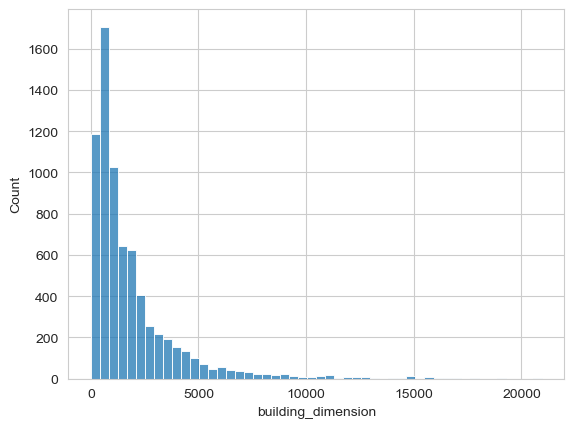

In [77]:
df_plot['building_dimension'].describe()
df_plot['building_dimension'].skew()
sns.histplot(df_plot['building_dimension'], bins=50)
df_plot['building_dimension'].skew()

In [79]:
train['building_dim_log'] = np.log1p(train['building_dimension'])
test['building_dim_log']  = np.log1p(test['building_dimension'])

,residential,building_painted,building_fenced,garden,settlement,building_dimension,numberofwindows,claim,building_1,building_2,building_3,building_4,building_dim_log
0,0,1,0,1,1,290.00000,0,0,True,False,False,False,5.673323
1,0,0,1,0,0,490.00000,4,0,True,False,False,False,6.196444
2,0,1,0,1,1,595.00000,0,0,True,False,False,False,6.390241
3,0,0,0,1,1,2840.00000,0,0,True,False,False,False,7.951911
4,0,0,1,0,0,680.00000,3,0,True,False,False,False,6.523562
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7155,1,0,0,1,1,1883.72753,0,0,True,False,False,False,7.541539
7156,0,0,0,1,1,1883.72753,0,1,False,True,False,False,7.541539
7157,0,0,0,1,1,1883.72753,0,0,True,False,False,False,7.541539
7158,0,0,0,1,1,1883.72753,0,0,True,False,False,False,7.541539


Now we can see the values look more normally distributed. 

-0.23202377702208163

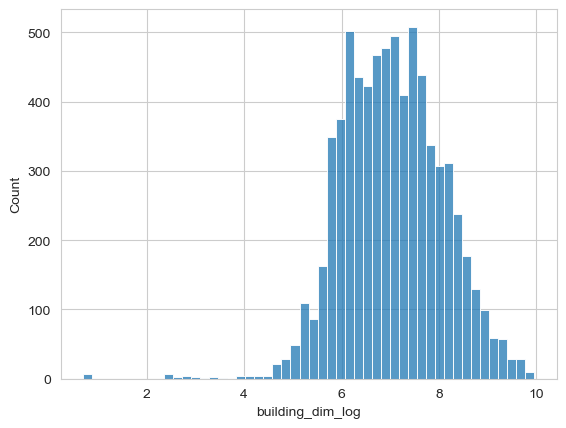

In [82]:
sns.histplot(train['building_dim_log'], bins=50)
train['building_dim_log'].skew()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


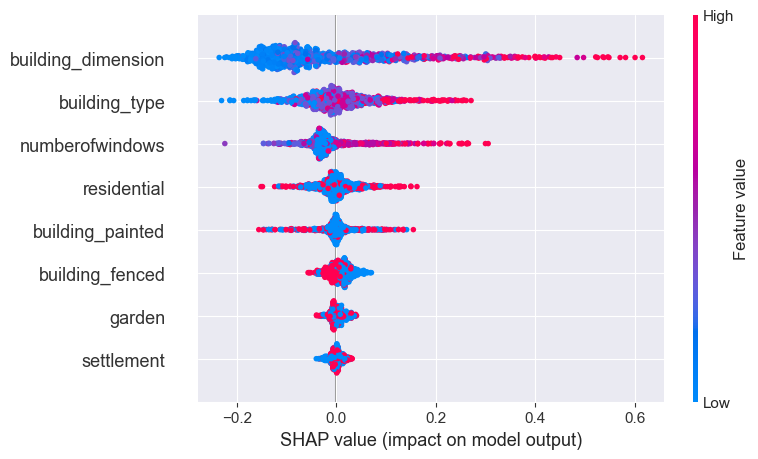

In [35]:
X_sample = X.sample(1000, random_state=42)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)
shap.summary_plot(shap_values[1], X_sample)

From the above SHAP plot we can see a detailed breakdown of which features matter the most and if they move the predictions towards 0 or 1 and how much they push the predictions by. Every dot on the plot represents a row, and it shows how that row's feature influenced the models output. The list on the left is sorted from most important to the least important. The X axis shows the actual SHAP value, positive meaning pushing predictions to 1 and negative meaning pushing predictions towards 0. The colouring of the dots show the feature values, high values are red, low values are blue and from the plot we can see a cluster of blue dots pulling the graph towards the left in building_dimension while there is a thin line of red dots reaching out to the right. 

The spread of building_dimension means the model relies mostly on this feature. The blue dot cluster indicates that small buildings lean towards predicting 0, no claim, while the red dots indicate large buildings predicting a 1, a claim. This makes sense as the data set is heavily imbalanced in favour of the 0 class. 

The other features are more difficult to interpret in this format as they represent categorical choices however we can note that from building_type and number of windows, the higher these are the more likeley they are influencing the prediction to be in a 1 class and vice versa. 

# Data modeling

As this is a classification task I will be using models that are suited for binary classification. 

##### LinearSVC (Linear Support Vector Classifier)

A linear classifier that finds the hyperplane separating two classes with maximum margin.
* Good at: High-dimensional data, fast training, text and tabular data.
* Weak at: Non-linear relationships, sensitive to scaling and class imbalance.
* Used for: Binary classification, baseline linear models, large feature spaces.

##### RandomForestClassifier

An ensemble of decision trees trained on random subsets of data and features.
* Good at: Non-linear relationships, mixed data types, feature importance estimation.
* Weak at: Slower than linear models, less interpretable, can overfit if not tuned.
* Used for: General-purpose tabular classification problems.

##### XGBClassifier (Extreme Gradient Boosting)

A highly optimized gradient boosting model that builds trees sequentially to correct errors.
* Good at: High accuracy, handling complex patterns, competitions and real-world tabular data.
* Weak at: Requires tuning, computationally heavier, less interpretable.
* Used for: High-performance classification and regression.

##### GaussianNB (Gaussian Naive Bayes)

A probabilistic classifier based on Bayes’ theorem assuming normal feature distributions.
* Good at: Very fast training, small datasets, high-dimensional problems.
* Weak at: Strong independence and normality assumptions.
* Used for: Baseline models, text classification, rapid prototyping.

##### GradientBoostingClassifier

An ensemble method that builds trees sequentially to minimize classification error.
* Good at: Non-linear patterns, strong predictive performance, controlled overfitting.
* Weak at: Slower training, sensitive to hyperparameters.
* Used for: Structured/tabular datasets where accuracy is important.

##### RandomOverSampler

A data resampling method that duplicates minority-class samples to balance the dataset.
* Good at: Improving recall for minority classes.
* Weak at: Can cause overfitting due to duplicated samples.
* Used for: Handling imbalanced classification problems before model training.

##### BalancedRandomForestClassifier

A Random Forest variant that balances each tree using resampling.
* Good at: Strong performance on highly imbalanced datasets.
* Weak at: Slightly noisier predictions than standard Random Forest.
* Used for: Imbalanced classification tasks (fraud, claims, medical data).

##### DecisionTreeClassifier

A single tree that splits data using feature thresholds.
* Good at: Interpretability, handling non-linear rules, no scaling needed.
* Weak at: Easily overfits, unstable to small data changes.
* Used for: Rule-based models, benchmarks, feature explainability.

In [36]:
# Convert Building type to dummies
train = pd.get_dummies(train, columns=["building_type"], prefix="building")
test = pd.get_dummies(test, columns=["building_type"], prefix="building")

In [98]:
# Split the data
feature_cols = [col for col in train.columns if col not in ['claim', 'building_dimension']]

# Features and target
X = train[feature_cols]
y = train['claim']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # preserves class distribution
)

In [96]:
y.value_counts(normalize=True)

claim
0    0.771788
1    0.228212
Name: proportion, dtype: float64

In [100]:
# LinearSVC

X_test = test[feature_cols]  

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)      
X_valid_scaled = scaler.transform(X_valid)          
X_test_scaled  = scaler.transform(X_test)           

# Train LinearSVC
svm = LinearSVC(class_weight='balanced', max_iter=1000000, dual=False)
svm.fit(X_train_scaled, y_train)

# Predict on validation split
y_pred = svm.predict(X_valid_scaled)

# Predict on the test set
y_test_preds = svm.predict(X_test_scaled)

# Evaluate
print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred, zero_division=0))

# Create CSV
submission = pd.DataFrame({
    'Customer Id': test_ids['customer_id'],
    'Claim': y_test_preds
})
submission.to_csv('submission.csv', index=False)


Accuracy: 0.6501396648044693
              precision    recall  f1-score   support

           0       0.84      0.67      0.75      1105
           1       0.34      0.58      0.43       327

    accuracy                           0.65      1432
   macro avg       0.59      0.62      0.59      1432
weighted avg       0.73      0.65      0.68      1432



In this case, the LinearSVC model achieves an overall accuracy of about 65%. For the majority class (0), precision is high at 0.84, but recall is only 0.67, meaning the model is good at predicting non-claims when it labels them as such, but it misses a significant portion of them. For the minority class (1), precision is low at 0.34 but recall is higher at 0.58, indicating that when the model predicts a claim, it is often wrong, but it catches a larger fraction of actual claims compared to the Random Forest (see below). The macro-average F1 of 0.59 shows moderate balance between classes, while the weighted F1 of 0.68 is dragged down by poorer performance on the minority class. Overall, scaling helps SVM models like LinearSVC, but this model is still less accurate than the unscaled Random Forest, though it slightly improves detection of claims.

In [107]:
# RandomForestClassifier
feature_cols = [col for col in train.columns if col != 'claim']
X = train[feature_cols]
y = train['claim']

# Split data again 
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(class_weight='balanced', n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

# Predict on validation
rf_y_pred = rf.predict(X_valid)

# Predict on test 
X_test_rf = test[X_train.columns]
rf_y_test_preds = rf.predict(X_test_rf)

# Evaluate
print("Accuracy:", accuracy_score(y_valid, rf_y_pred))
print(classification_report(y_valid, rf_y_pred, zero_division=0))

# Feature importances
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)
print(feature_importance_df.head(10))

# Create CSV
submission = pd.DataFrame({
    'Customer Id': test_ids['customer_id'],
    'Claim': rf_y_test_preds
})
submission.to_csv('submission.csv', index=False)


Accuracy: 0.702513966480447
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1105
           1       0.35      0.35      0.35       327

    accuracy                           0.70      1432
   macro avg       0.58      0.58      0.58      1432
weighted avg       0.70      0.70      0.70      1432

               feature  importance
5   building_dimension    0.411812
11    building_dim_log    0.403402
6      numberofwindows    0.083619
0          residential    0.026848
1     building_painted    0.017377
7           building_1    0.013137
10          building_4    0.012718
8           building_2    0.011211
9           building_3    0.010003
2      building_fenced    0.003524


The model has an overall accuracy of about 70%, meaning it correctly classifies roughly seven out of ten instances. For the majority class (0 – no claim), both precision and recall are 0.81, resulting in an F1-score of 0.81, which shows the model predicts non-claims fairly consistently. For the minority class (1 – claim), precision, recall, and F1-score are all 0.35, indicating the model struggles to correctly identify claims and often misclassifies them. The macro-average F1 of 0.58 reflects the imbalance in performance between the classes, while the weighted F1 of 0.70 is higher because it accounts for the dominance of the majority class. Overall, the model is moderately good for predicting non-claims but performs poorly for predicting actual claims.

In [108]:
xgb = XGBClassifier()

xgb.fit(X_train, y_train)

# Predict on validation split ONLY
xgb_y_pred = xgb.predict(X_valid)

# Predict on the test set
xgb_y_test_preds = xgb.predict(test)

# Evaluate
print("Accuracy:", accuracy_score(y_valid, xgb_y_pred))
print(classification_report(y_valid, xgb_y_pred))


xgb_importances = xgb.feature_importances_
xgb_feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_importances
}).sort_values(by='importance', ascending=False)
print(xgb_feature_importance_df.head(10))

# Create CSV
submission = pd.DataFrame({
    'Customer Id': test_ids['customer_id'],
    'Claim': xgb_y_test_preds
})
submission.to_csv('submission.csv', index=False)

Accuracy: 0.7730446927374302
              precision    recall  f1-score   support

           0       0.80      0.94      0.86      1105
           1       0.51      0.22      0.30       327

    accuracy                           0.77      1432
   macro avg       0.65      0.58      0.58      1432
weighted avg       0.73      0.77      0.74      1432

               feature  importance
5   building_dimension    0.165562
10          building_4    0.161369
9           building_3    0.097491
7           building_1    0.095981
6      numberofwindows    0.091867
4           settlement    0.086382
0          residential    0.086040
2      building_fenced    0.082380
1     building_painted    0.070625
8           building_2    0.062304


The model achieves an overall accuracy of 77%, indicating that it correctly classifies the majority of instances. It performs very well on the majority class (0 – no claim), with a high recall of 94% and precision of 80%, resulting in a strong F1-score of 0.86. However, its performance on the minority class (1 – claim) is poor, with recall only 22%, precision 51%, and F1-score 0.30, showing that it frequently fails to identify actual claims. The macro-average F1 of 0.58 confirms the imbalance in performance between classes, while the weighted F1 of 0.74 is higher because it is dominated by the majority class. Overall, the model is reliable for predicting non-claims but struggles significantly with detecting claims, highlighting a need for better handling of class imbalance.

In [109]:
# Gaussian

nb = GaussianNB()
nb.fit(X_train, y_train)

# Predict on validation split ONLY
nb_y_pred = nb.predict(X_valid)

# Predict on the test set
nb_y_test_preds = nb.predict(test)

# Evaluate
print("Accuracy:", accuracy_score(y_valid, nb_y_pred))
print(classification_report(y_valid, nb_y_pred))

# Create CSV
submission = pd.DataFrame({
    'Customer Id': test_ids['customer_id'],
    'Claim': nb_y_test_preds
})
submission.to_csv('submission.csv', index=False)


Accuracy: 0.7604748603351955
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1105
           1       0.47      0.33      0.39       327

    accuracy                           0.76      1432
   macro avg       0.64      0.61      0.62      1432
weighted avg       0.74      0.76      0.75      1432



The GaussianNB model does a reasonable job predicting non-claims but struggles with claims, which is common for imbalanced datasets. It’s similar to Random Forest in accuracy but less reliable for detecting the minority class. For the majority class (0), precision is 0.82 and recall is 0.89, which means when the model predicts “no claim,” it’s correct 82% of the time, and it correctly identifies 89% of all actual non-claims.

For the minority class (1), precision is 0.47 and recall is 0.33, meaning that when it predicts a claim, it’s correct less than half the time, and it only identifies 33% of all actual claims.

In [131]:
# GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_valid)
print("Accuracy:", accuracy_score(y_valid, y_pred_gb))
print(classification_report(y_valid, y_pred_gb))

gb_y_test_preds = gb.predict(test)


submission = pd.DataFrame({
    'Customer Id': test_ids['customer_id'],
    'Claim': gb_y_test_preds
})
submission.to_csv('submission.csv', index=False)

Accuracy: 0.7660614525139665
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1105
           1       0.48      0.24      0.32       327

    accuracy                           0.77      1432
   macro avg       0.64      0.58      0.59      1432
weighted avg       0.73      0.77      0.74      1432



The model achieved an overall accuracy of 76.6%, meaning it correctly predicted the outcome for roughly three-quarters of the validation set. However, looking at the class-specific metrics reveals an imbalance in performance. For the majority class (0), the model performs well, with precision of 0.80 (most predicted positives are correct), recall of 0.92 (it captures most actual positives), and an F1-score of 0.86, indicating strong overall performance for this class. But for the minority class (1), the model struggles: precision is 0.48, meaning less than half of predicted positives are correct, recall is only 0.24, showing that the model misses most actual positives, and the F1-score of 0.32 highlights poor predictive power. The macro average F1-score of 0.59 confirms that performance across classes is uneven, and the weighted F1-score of 0.74 is largely driven by the majority class. This pattern indicates that the model is biased toward predicting the majority class and may require techniques like class weighting, resampling, or different metrics to better capture the minority class.

In [120]:
# RandomOverSampler

# Keep only raw features
raw_features = X_train.drop(columns=['building_dim_log'])
X_valid_raw = X_valid.drop(columns=['building_dim_log']).copy()

# RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(raw_features, y_train)


# Train Random Forest
rf_ros = RandomForestClassifier(
    n_estimators=500,
    random_state=42
)
rf_ros.fit(X_train_res, y_train_res)

# Predict probabilities on validation set
probs = rf_ros.predict_proba(X_valid_raw)[:, 1]

# Apply threshold
y_pred = (probs > 0.35).astype(int)

# Evaluate
print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Accuracy: 0.6403631284916201
              precision    recall  f1-score   support

           0       0.82      0.69      0.75      1105
           1       0.31      0.47      0.38       327

    accuracy                           0.64      1432
   macro avg       0.56      0.58      0.56      1432
weighted avg       0.70      0.64      0.66      1432



Oversampling improved recall for the minority class compared to the raw model, but at a significant cost to overall accuracy and precision for class 1. The model now detects more claims but makes more false positives, so it’s a trade-off.

In [125]:
# BalancedRandomForestClassifier

feature_cols = [col for col in X_train.columns if col != 'building_dim_log']
X_train_clean = X_train[feature_cols].copy()
X_valid_clean = X_valid[feature_cols].copy()
X_test_clean  = test[feature_cols].copy()

# Train  
brf = BalancedRandomForestClassifier(
    n_estimators=500,
    sampling_strategy='auto',
    replacement=True,   
    bootstrap=False, 
    random_state=42
)
brf.fit(X_train_clean, y_train)

# Predict  
probs = brf.predict_proba(X_valid_clean)[:, 1]

# Apply a threshold for classification
threshold = 0.35
y_pred = (probs > threshold).astype(int)

# Evaluate
print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

# Predict on test set
y_test_pred_brf = brf.predict(X_test_clean)

# Create submission CSV
submission = pd.DataFrame({
    'Customer Id': test_ids['customer_id'],
    'Claim': y_test_pred_brf
})
submission.to_csv('submission.csv', index=False)

Accuracy: 0.5125698324022346
              precision    recall  f1-score   support

           0       0.85      0.45      0.59      1105
           1       0.28      0.72      0.40       327

    accuracy                           0.51      1432
   macro avg       0.56      0.59      0.50      1432
weighted avg       0.72      0.51      0.55      1432



The classification report shows that the model’s overall accuracy is 51%, meaning it correctly predicts just over half of the cases. For the majority class (0), precision is high at 85%, indicating that when the model predicts class 0, it is usually correct, but recall is low at 45%, so it misses more than half of the actual class 0 cases. For the minority class (1), recall is higher at 72%, meaning the model catches most of the actual claims, but precision is very low at 28%, so many predicted claims are false positives. The F1-scores reflect this imbalance, with class 0 at 0.59 and class 1 at 0.40, and the macro average F1 is 0.50. Weighted averages account for the imbalance, giving an F1 of 0.55. Overall, the model favors detecting the minority class at the expense of the majority class, which results in low overall accuracy.

In [129]:
# DecisionTreeClassifier
feature_cols = [col for col in X_train.columns if col != 'building_dim_log']
X_train_clean = X_train[feature_cols].copy()
X_valid_clean = X_valid[feature_cols].copy()
X_test_clean  = test[feature_cols].copy()

# Initialize and train
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

# Predict on validation set
dtc_y_pred = dtc.predict(X_valid)

# Predict on test set
dtc_y_test_preds = dtc.predict(test)

# Evaluate on validation set
print("Accuracy:", accuracy_score(y_valid, dtc_y_pred))
print(classification_report(y_valid, dtc_y_pred))

# Save submission
submission = pd.DataFrame({
    'Customer Id': test_ids['customer_id'],
    'Claim': dtc_y_test_preds
})
submission.to_csv('submission.csv', index=False)


Accuracy: 0.7332402234636871
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1105
           1       0.39      0.31      0.35       327

    accuracy                           0.73      1432
   macro avg       0.60      0.59      0.59      1432
weighted avg       0.71      0.73      0.72      1432



The Decision Tree model achieved an overall accuracy of 73%, meaning it correctly predicted the target for roughly three-quarters of the validation set. For class 0, it performs well with high precision (0.81) and recall (0.86), giving a strong F1-score of 0.83, indicating reliable identification of non-claim cases. Class 1, however, is less well captured: the model only correctly identifies 31% of actual claim cases (recall 0.31) and has lower precision (0.39), resulting in an F1-score of 0.35. Overall, the model is biased toward the majority class (0), performing much better at predicting non-claims than claims, which is common in imbalanced datasets. The macro average F1 of 0.59 reflects moderate performance across both classes, while the weighted average F1 of 0.72 is skewed by the majority class.